In [1]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaharin","key":"fe56d6353949179c30ec3e24442a9a66"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 97% 0.99G/1.03G [00:07<00:00, 43.2MB/s]
100% 1.03G/1.03G [00:07<00:00, 151MB/s] 


In [4]:
!unzip -q asl-alphabet.zip -d /content/asl_alphabet

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout,Conv2D, MaxPooling2D, Flatten
import cv2, numpy as np, matplotlib.pyplot as plt

In [6]:
train_ds_raw = keras.utils.image_dataset_from_directory(
directory="/content/asl_alphabet",
labels="inferred",
label_mode="int",
batch_size=32,
image_size=(224,224),
validation_split=0.2,
subset="training",
seed=123
)

Found 87028 files belonging to 2 classes.
Using 69623 files for training.


In [7]:
val_ds_raw = keras.utils.image_dataset_from_directory(
directory="/content/asl_alphabet",
labels="inferred",
label_mode="int",
batch_size=32,
image_size=(224,224),
validation_split=0.2,
subset="validation",
seed=123
)
print("Classes:", train_ds_raw.class_names)

Found 87028 files belonging to 2 classes.
Using 17405 files for validation.
Classes: ['asl_alphabet_test', 'asl_alphabet_train']


In [8]:
class_names = train_ds_raw.class_names
print("Classes:", class_names)

Classes: ['asl_alphabet_test', 'asl_alphabet_train']


In [9]:
import tensorflow as tf

def process(image, label):
    # Convert image to float and normalize
    image = tf.cast(image, tf.float32) / 255.0
    # Resize all images to the same shape (e.g., 224x224)
    image = tf.image.resize(image, (224, 224))
    return image, label



In [10]:
train_ds = train_ds_raw.map(process)
val_ds = val_ds_raw.map(process)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation="softmax"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,277,826 (84.98 MB)

 Trainable params: 22,277,826 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer="adam",
loss="sparse_categorical_crossentropy",
metrics=["accuracy"])


In [14]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 151s 66ms/step - accuracy: 0.9987 - loss: 0.0379 - val_accuracy: 0.9996 - val_loss: 0.1036
Epoch 2/5
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.9996 - loss: 0.0384 - val_accuracy: 0.9996 - val_loss: 0.0049
Epoch 3/5
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.9996 - loss: 0.0079 - val_accuracy: 0.9996 - val_loss: 0.0043
Epoch 4/5
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 135s 62ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9996 - val_loss: 0.0040
Epoch 5/5
2176/2176 ━━━━━━━━━━━━━━━━━━━━ 142s 62ms/step - accuracy: 0.9996 - loss: 0.0045 - val_accuracy: 0.9996 - val_loss: 0.0039


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Gesture: asl_alphabet_train


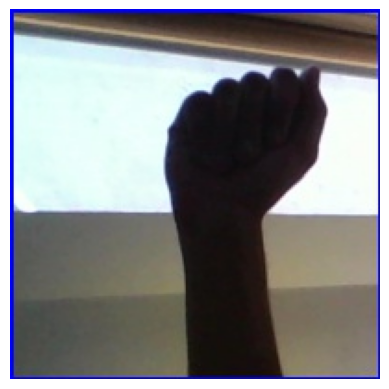

In [15]:
test_img = cv2.imread('/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
test_img = cv2.resize(test_img, (224,224))
test_input = np.expand_dims(test_img/255.0, axis=0)
pred = model.predict(test_input)
print("Predicted Gesture:", class_names[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Gesture: asl_alphabet_train


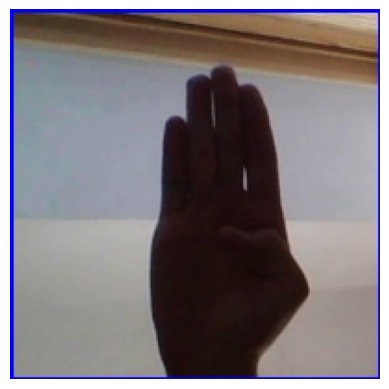

In [16]:
test_img = cv2.imread('/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test/B_test.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
test_img = cv2.resize(test_img, (224,224))
test_input = np.expand_dims(test_img/255.0, axis=0)
pred = model.predict(test_input)
print("Predicted Gesture:", class_names[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Gesture: asl_alphabet_train


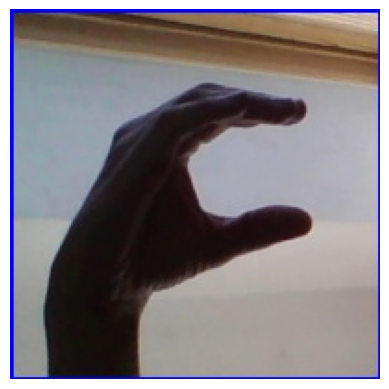

In [17]:
test_img = cv2.imread('/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test/C_test.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
test_img = cv2.resize(test_img, (224,224))
test_input = np.expand_dims(test_img/255.0, axis=0)
pred = model.predict(test_input)
print("Predicted Gesture:", class_names[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Gesture: asl_alphabet_train


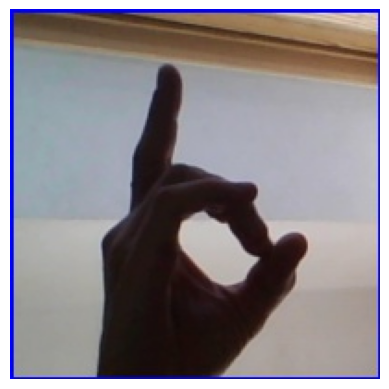

In [18]:
test_img = cv2.imread('/content/asl_alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg')
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
test_img = cv2.resize(test_img, (224,224))
test_input = np.expand_dims(test_img/255.0, axis=0)
pred = model.predict(test_input)
print("Predicted Gesture:", class_names[np.argmax(pred)])